# Multitask Learning Experiments, and Q2 Classification

This notebook includes experiments with multitask learning using Keras, as well as classification and metrics for the q2 membrane bound vs water soluble task that is included as part of the DeepLoc dataset

In [1]:
import json

from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

Using TensorFlow backend.


In [2]:
np.random.seed(42)

### Data Loading

In [3]:
seq_id_to_q2 = {}
seq_id_to_q10 = {}
seq_list = []

for record in SeqIO.parse("../data/deeploc_data_6000.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    desc_split = description.split(" ")
    # Use ID for indexing
    ID = desc_split[0]
    # Split label into Q10 subcellular location and Q2 membrane bound vs water soluble
    label = desc_split[1]
    loc_label = label[:len(label)-2]
    mem_label = label[-1]
    seq_id_to_q10[ID] = loc_label
    seq_id_to_q2[ID] = mem_label

In [4]:
# Look at percentiles for sequence length
seq_df = pd.DataFrame(seq_list)
seq_df.describe(percentiles=[.90, .95, .99])

,0
count,13856.000000
mean,520.753464
std,433.220632
min,40.000000
50%,421.000000
90%,995.000000
95%,1291.250000
99%,2168.800000
max,5654.000000


In [5]:
train_arrays = np.load('../data/output_deeploc_train_6000.npz', allow_pickle=True)
valid_arrays = np.load('../data/output_deeploc_valid_6000.npz', allow_pickle=True)
test_arrays = np.load('../data/output_deeploc_test_6000.npz', allow_pickle=True)

In [6]:
id_dict = {'Cell.membrane': 0, 
 'Cytoplasm': 1, 
 'Endoplasmic.reticulum': 2, 
 'Golgi.apparatus': 3, 
 'Lysosome/Vacuole': 4,
 'Mitochondrion': 5, 
 'Nucleus': 6,
 'Peroxisome': 7, 
 'Plastid': 8,
 'Extracellular': 9}

id_dict_mem = {
    'M': 0,
    'S': 1,
    'U': 2
}

reverse_id_dict = {value: key for key, value in id_dict.items()}
reverse_id_dict_mem = {value: key for key, value in id_dict_mem.items()}

In [7]:
def gen_df(embeddings):
    """
    Iterate over all of the sequence IDs in the given subset of the dataset (embeddings),
    as a nested numpy array. Produce a numpy array of the average embeddings for each
    sequence, as will a list of the labels by looking up the sequence IDs in seq_id_to_label
    
    Args:
        embeddings (numpy.lib.npyio.NpzFile): Nested numpy array containing embeddings for each sequence ID
        seq_id_to_label (dict[str,str]): Map from sequence ID to classification label
    
    Returns:
        output (pd.DataFrame): Average embeddings for each sequence
        labels (list[str])
    """
    keys = embeddings.files
    output, loc_labels, mem_labels = [], [], []
    for key in keys:
        d = embeddings[key].item()["avg"]
        loc_labels.append(seq_id_to_q10[key])
        mem_labels.append(seq_id_to_q2[key])
        output.append(d)
    return pd.DataFrame(output), loc_labels, mem_labels

In [8]:
train_df, train_loc_labels, train_mem_labels = gen_df(train_arrays)
valid_df, valid_loc_labels, valid_mem_labels = gen_df(valid_arrays)
test_df, test_loc_labels, test_mem_labels = gen_df(test_arrays)

In [9]:
# Look at distribution of classes for binary classification task. U stands for unknown - we can skip those samples
pd.Series(train_mem_labels).value_counts()

U    3753
S    3700
M    2521
dtype: int64

### Logistic Regression (Q2)

Applying Logistic Regression to the membrane bound vs water soluble q2 classification problem, we were able to obtain 87% accuracy on the test set.

In [10]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_mem_labels = np.array(train_mem_labels + valid_mem_labels)

In [11]:
train_valid_df = train_valid_df[train_valid_mem_labels != 'U']
train_valid_mem_labels = train_valid_mem_labels[train_valid_mem_labels != 'U']

In [12]:
test_mem_labels_q2 = np.array(test_mem_labels)
test_mem_df = test_df[test_mem_labels_q2 != 'U']
test_mem_labels_q2 = test_mem_labels_q2[test_mem_labels_q2 != 'U']

In [13]:
train_valid_df.shape

(6911, 768)

In [14]:
clf = LogisticRegression(random_state=42)
clf.fit(train_valid_df, train_valid_mem_labels)

/Users/rdedhia/Documents/ucsd/capstone/tape/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
clf.score(train_valid_df, train_valid_mem_labels)

0.9256258139198379

In [16]:
clf.score(test_mem_df, test_mem_labels_q2)

0.8679245283018868

In [17]:
logreg_q2_test_preds = clf.predict(test_mem_df)

### Keras DNN (Q2)

Applying a Keras DNN with two hidden layers of 32 nodes to the membrane bound vs water soluble q2 classification problem, we were able to obtain 89% accuracy on the test set.

The DeepLoc dataset has many sequences with an unknown label for the q2 task, so we are excluding those samples from training.

In [18]:
train_mem_labels_q2 = np.array(train_mem_labels)
valid_mem_labels_q2 = np.array(valid_mem_labels)
test_mem_labels_q2 = np.array(test_mem_labels)

train_df_q2 = train_df[train_mem_labels_q2 != 'U']
valid_df_q2 = valid_df[valid_mem_labels_q2 != 'U']
test_df_q2 = test_df[test_mem_labels_q2 != 'U']

train_mem_labels_q2 = train_mem_labels_q2[train_mem_labels_q2 != 'U']
valid_mem_labels_q2 = valid_mem_labels_q2[valid_mem_labels_q2 != 'U']
test_mem_labels_q2 = test_mem_labels_q2[test_mem_labels_q2 != 'U']

train_lab_mem = [id_dict_mem[label] for label in train_mem_labels_q2]
valid_lab_mem = [id_dict_mem[label] for label in valid_mem_labels_q2]
test_lab_mem = [id_dict_mem[label] for label in test_mem_labels_q2]

In [19]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='relu'))
model.add(Dense(32, input_dim=768, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
]

In [21]:
history = model.fit(train_df_q2, to_categorical(train_lab_mem), 
          validation_data=(valid_df_q2, to_categorical(valid_lab_mem)),
          epochs=500, batch_size=64, callbacks=keras_callbacks)

Train on 6221 samples, validate on 690 samples
Epoch 1/500
6221/6221 [==============================] - 0s 78us/step - loss: 0.4219 - accuracy: 0.8198 - val_loss: 0.3285 - val_accuracy: 0.8645
Epoch 2/500
6221/6221 [==============================] - 0s 37us/step - loss: 0.3176 - accuracy: 0.8729 - val_loss: 0.2977 - val_accuracy: 0.8696
Epoch 3/500
6221/6221 [==============================] - 0s 37us/step - loss: 0.2943 - accuracy: 0.8836 - val_loss: 0.2848 - val_accuracy: 0.8746
Epoch 4/500
6221/6221 [==============================] - 0s 41us/step - loss: 0.2788 - accuracy: 0.8859 - val_loss: 0.2786 - val_accuracy: 0.8848
Epoch 5/500
6221/6221 [==============================] - 0s 37us/step - loss: 0.2662 - accuracy: 0.8909 - val_loss: 0.2681 - val_accuracy: 0.8891
Epoch 6/500
6221/6221 [==============================] - 0s 42us/step - loss: 0.2586 - accuracy: 0.8953 - val_loss: 0.2750 - val_accuracy: 0.8833
Epoch 7/500
6221/6221 [==============================] - 0s 38us/step - loss:

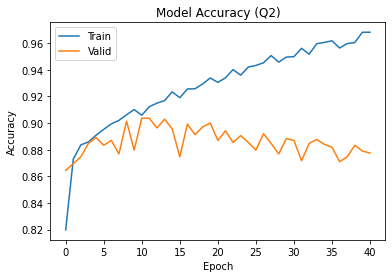

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (Q2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [23]:
model.evaluate(test_df_q2, to_categorical(test_lab_mem))

1749/1749 [==============================] - 0s 31us/step


[0.5096434573059835, 0.8579187989234924]

In [24]:
dnn_q2_test_probs = model.predict(test_df_q2)
dnn_q2_test_preds_num = np.argmax(dnn_q2_test_probs, axis=1)
dnn_q2_test_preds = [reverse_id_dict_mem[pred] for pred in dnn_q2_test_preds_num]

### Logistic Regression (Q10)

Applying Logistic Regression to the subcellular location (q10) classification task, we were able to obtain 66% accuracy on the test set.

In [25]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_loc_labels = train_loc_labels + valid_loc_labels

In [26]:
print(train_valid_df.shape)
print(len(train_loc_labels))
print(len(valid_loc_labels))

(11083, 768)
9974
1109


In [27]:
clf = LogisticRegression(random_state=42)
clf.fit(train_valid_df, train_valid_loc_labels)

/Users/rdedhia/Documents/ucsd/capstone/tape/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rdedhia/Documents/ucsd/capstone/tape/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
clf.score(train_valid_df, train_valid_loc_labels)

0.7950915817017054

In [29]:
clf.score(test_df, test_loc_labels)

0.6628200504868373

In [30]:
logreg_test_preds = clf.predict(test_df)

### Keras DNN (Q10)

Applying a Keras DNN with two hidden layers of 32 nodes each to the subcellular location (q10) classification task, we were able to obtain 65% accuracy on the test set.

In [31]:
train_lab = [id_dict[label] for label in train_loc_labels]
valid_lab = [id_dict[label] for label in valid_loc_labels]
test_lab = [id_dict[label] for label in test_loc_labels]

In [32]:
model = Sequential()
model.add(Dense(32, input_dim=768, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=50, mode='min', min_delta=0.0001)
]

In [34]:
history = model.fit(train_df, to_categorical(train_lab), 
          validation_data=(valid_df, to_categorical(valid_lab)),
          epochs=500, batch_size=64, callbacks=keras_callbacks)

Train on 9974 samples, validate on 1109 samples
Epoch 1/500
9974/9974 [==============================] - 1s 51us/step - loss: 1.5116 - accuracy: 0.4565 - val_loss: 1.1840 - val_accuracy: 0.5816
Epoch 2/500
9974/9974 [==============================] - 0s 33us/step - loss: 1.1370 - accuracy: 0.6011 - val_loss: 1.0830 - val_accuracy: 0.6069
Epoch 3/500
9974/9974 [==============================] - 0s 36us/step - loss: 1.0580 - accuracy: 0.6265 - val_loss: 1.0529 - val_accuracy: 0.6276
Epoch 4/500
9974/9974 [==============================] - 0s 36us/step - loss: 1.0029 - accuracy: 0.6442 - val_loss: 1.0305 - val_accuracy: 0.6474
Epoch 5/500
9974/9974 [==============================] - 0s 33us/step - loss: 0.9691 - accuracy: 0.6567 - val_loss: 1.0075 - val_accuracy: 0.6519
Epoch 6/500
9974/9974 [==============================] - 0s 36us/step - loss: 0.9438 - accuracy: 0.6646 - val_loss: 0.9886 - val_accuracy: 0.6682
Epoch 7/500
9974/9974 [==============================] - 0s 36us/step - loss

9974/9974 [==============================] - 0s 39us/step - loss: 0.5074 - accuracy: 0.8262 - val_loss: 1.0162 - val_accuracy: 0.7042
Epoch 57/500
9974/9974 [==============================] - 0s 37us/step - loss: 0.5117 - accuracy: 0.8246 - val_loss: 1.0217 - val_accuracy: 0.6988
Epoch 58/500
9974/9974 [==============================] - 0s 35us/step - loss: 0.5166 - accuracy: 0.8228 - val_loss: 1.0572 - val_accuracy: 0.6934
Epoch 59/500
9974/9974 [==============================] - 0s 38us/step - loss: 0.5130 - accuracy: 0.8231 - val_loss: 1.0786 - val_accuracy: 0.6961
Epoch 60/500
9974/9974 [==============================] - 0s 37us/step - loss: 0.5061 - accuracy: 0.8292 - val_loss: 1.0650 - val_accuracy: 0.6835
Epoch 61/500
9974/9974 [==============================] - 0s 33us/step - loss: 0.5059 - accuracy: 0.8240 - val_loss: 1.0702 - val_accuracy: 0.6934
Epoch 62/500
9974/9974 [==============================] - 0s 37us/step - loss: 0.4830 - accuracy: 0.8304 - val_loss: 1.0468 - val_a

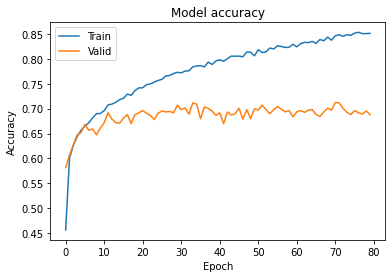

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [36]:
model.evaluate(test_df, to_categorical(test_lab))

2773/2773 [==============================] - 0s 26us/step


[1.336217233260272, 0.636134147644043]

In [37]:
dnn_test_probs = model.predict(test_df)
dnn_test_preds_num = np.argmax(dnn_test_probs, axis=1)
dnn_test_preds = [reverse_id_dict[pred] for pred in dnn_test_preds_num]

### Metrics

Here, we take a look at the classification report (precision and recall) as well as the confusion matrix for all four models above (logistic regression q2, logistic regression q10, keras DNN q2, keras DNN q10).

One of the major takeaways is that for the subcellular location task, the model performance is considerably worse on the classes that appear least frequently in the dataset, such as Golgi.apparatus, Lysosome/Vacuole, and Peroxisome. Also, the Cytoplasm and Nucleus classes are commonly confused, which is in line with our intuition that they have similar embedding spaces after looking at the PCA results in notebook 4.

#### Logistic Regression (Q2)

In [38]:
print("Logistic Regression Classification Report (Q2)\n")
print(classification_report(test_mem_labels_q2, logreg_q2_test_preds))

Logistic Regression Classification Report (Q2)

              precision    recall  f1-score   support

           M       0.87      0.81      0.84       743
           S       0.87      0.91      0.89      1006

    accuracy                           0.87      1749
   macro avg       0.87      0.86      0.86      1749
weighted avg       0.87      0.87      0.87      1749



In [39]:
logreg_cm = confusion_matrix(test_mem_labels_q2, logreg_q2_test_preds)

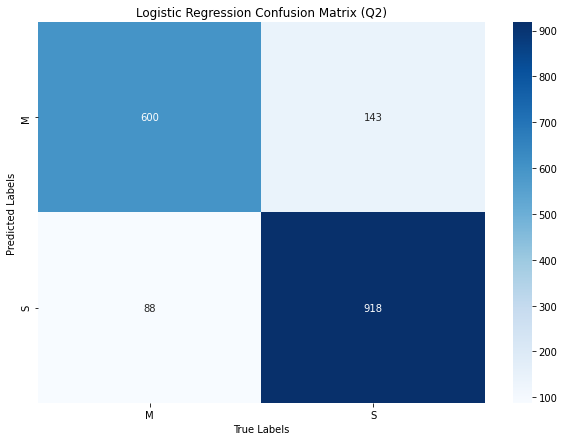

In [40]:
df_cm = pd.DataFrame(logreg_cm, index=sorted(id_dict_mem.keys())[:2], columns=sorted(id_dict_mem.keys())[:2])
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Logistic Regression Confusion Matrix (Q2)")
plt.show(fig)

#### Logistic Regression (Q10)

In [41]:
print("Logistic Regression Classification Report (Q10)\n")
print(classification_report(test_loc_labels, logreg_test_preds))

Logistic Regression Classification Report (Q10)

                       precision    recall  f1-score   support

        Cell.membrane       0.65      0.67      0.66       273
            Cytoplasm       0.53      0.44      0.48       508
Endoplasmic.reticulum       0.52      0.47      0.49       173
        Extracellular       0.88      0.89      0.89       393
      Golgi.apparatus       0.49      0.24      0.32        70
     Lysosome/Vacuole       0.29      0.12      0.17        64
        Mitochondrion       0.69      0.68      0.68       302
              Nucleus       0.66      0.82      0.73       808
           Peroxisome       0.38      0.10      0.16        30
              Plastid       0.72      0.68      0.70       152

             accuracy                           0.66      2773
            macro avg       0.58      0.51      0.53      2773
         weighted avg       0.65      0.66      0.65      2773



In [42]:
logreg_cm = confusion_matrix(test_loc_labels, logreg_test_preds)

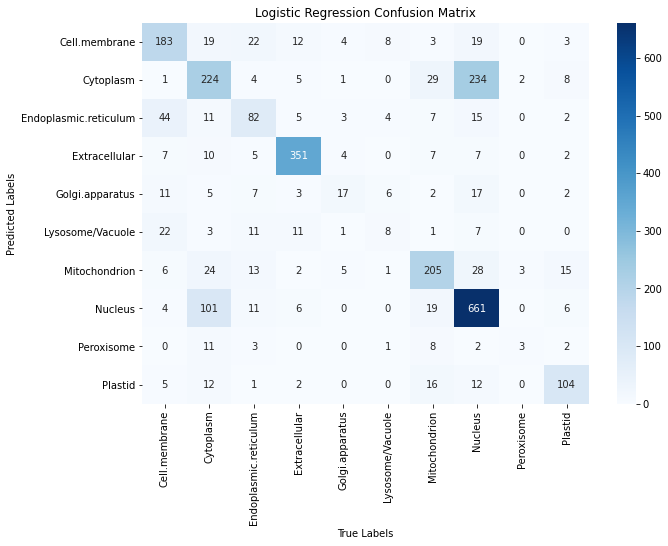

In [43]:
df_cm = pd.DataFrame(logreg_cm, index=sorted(id_dict.keys()), columns=sorted(id_dict.keys()))
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Logistic Regression Confusion Matrix")
plt.show(fig)

#### Keras DNN (Q2)

In [44]:
print("Keras DNN Classification Report Q2\n")
print(classification_report(test_mem_labels_q2, dnn_q2_test_preds))

Keras DNN Classification Report Q2

              precision    recall  f1-score   support

           M       0.82      0.85      0.84       743
           S       0.89      0.86      0.88      1006

    accuracy                           0.86      1749
   macro avg       0.85      0.86      0.86      1749
weighted avg       0.86      0.86      0.86      1749



In [45]:
dnn_cm = confusion_matrix(test_mem_labels_q2, dnn_q2_test_preds)

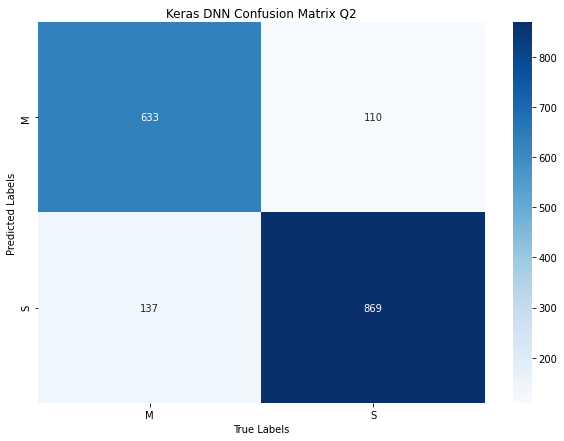

In [46]:
df_cm = pd.DataFrame(dnn_cm, index=sorted(id_dict_mem.keys())[:2], columns=sorted(id_dict_mem.keys())[:2])
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Keras DNN Confusion Matrix Q2")
plt.show(fig)

#### Keras DNN (Q10)

In [47]:
print("Keras DNN Classification Report Q10\n")
print(classification_report(test_loc_labels, dnn_test_preds))

Keras DNN Classification Report Q10

                       precision    recall  f1-score   support

        Cell.membrane       0.72      0.58      0.64       273
            Cytoplasm       0.54      0.42      0.47       508
Endoplasmic.reticulum       0.48      0.37      0.42       173
        Extracellular       0.83      0.87      0.84       393
      Golgi.apparatus       0.25      0.24      0.25        70
     Lysosome/Vacuole       0.32      0.38      0.34        64
        Mitochondrion       0.64      0.64      0.64       302
              Nucleus       0.66      0.79      0.72       808
           Peroxisome       0.14      0.03      0.05        30
              Plastid       0.59      0.77      0.67       152

             accuracy                           0.64      2773
            macro avg       0.52      0.51      0.50      2773
         weighted avg       0.63      0.64      0.63      2773



In [48]:
dnn_cm = confusion_matrix(test_loc_labels, dnn_test_preds)

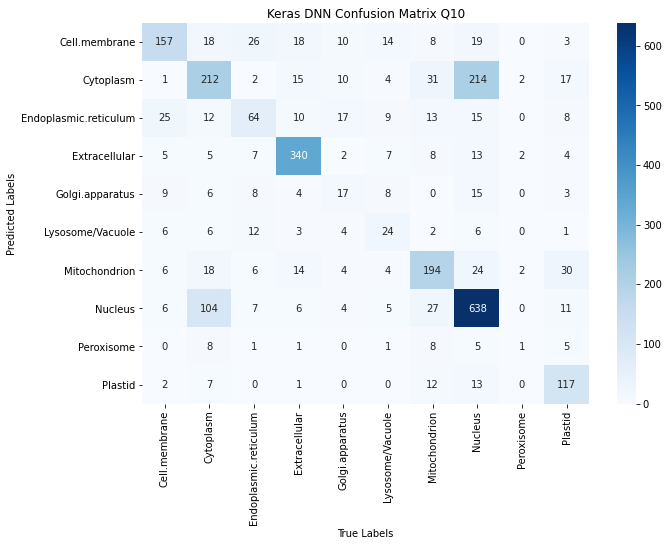

In [49]:
df_cm = pd.DataFrame(dnn_cm, index=sorted(id_dict.keys()), columns=sorted(id_dict.keys()))
plt.figure(figsize = (10,7))
fig = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Keras DNN Confusion Matrix Q10")
plt.show(fig)

### Multitask Learning

#### Q10 / Q3

Treating membrane bound vs water soluble q2 classification as a three class problem by including the unknown class to prevent having missing samples for the q10 subcellular location task.

The model is a Keras DNN w/ two hidden layers of 32 nodes each, and two output heads for the membrane bound vs water soluble vs unkonwn task, and the subcellular location task, each with a softmax activation function.

The results are as follows:
* 71% accuracy on membrane bound vs water soluble protein
* 64% accuracy on subcellular location

In [50]:
# Create arrays for all labels (loc=q10, mem=q3)
train_loc_labels_mtu = np.array(train_loc_labels)
valid_loc_labels_mtu = np.array(valid_loc_labels)
test_loc_labels_mtu = np.array(test_loc_labels)

train_mem_labels_mtu = np.array(train_mem_labels)
valid_mem_labels_mtu = np.array(valid_mem_labels)
test_mem_labels_mtu = np.array(test_mem_labels)

# Create new label lists with ints instead of strings
train_lab_loc_u = [id_dict[label] for label in train_loc_labels_mtu]
valid_lab_loc_u = [id_dict[label] for label in valid_loc_labels_mtu]
test_lab_loc_u = [id_dict[label] for label in test_loc_labels_mtu]

train_lab_mem_u = [id_dict_mem[label] for label in train_mem_labels_mtu]
valid_lab_mem_u = [id_dict_mem[label] for label in valid_mem_labels_mtu]
test_lab_mem_u = [id_dict_mem[label] for label in test_mem_labels_mtu]

In [51]:
keras.backend.clear_session()

visible = keras.Input(shape=(768,))
h1 = Dense(32, activation='relu')(visible)
h2 = Dense(32, activation='relu')(h1)

output_q10 = Dense(10, activation='softmax', name='q10')(h2)
output_q3 = Dense(3, activation='softmax', name='q3')(h2)

model = keras.Model(inputs=visible, outputs=[output_q10, output_q3])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              optimizer='adam', metrics=['accuracy', 'accuracy'])

In [52]:
keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
]

In [53]:
history = model.fit(train_df,
                    [to_categorical(train_lab_loc_u), to_categorical(train_lab_mem_u)],
                    validation_data=(valid_df, [to_categorical(valid_lab_loc_u), to_categorical(valid_lab_mem_u)]),
                    epochs=200, batch_size=64, callbacks=keras_callbacks)

Train on 9974 samples, validate on 1109 samples
Epoch 1/200
9974/9974 [==============================] - 1s 70us/step - loss: 2.2447 - q10_loss: 1.4609 - q3_loss: 0.7839 - q10_accuracy: 0.4883 - q3_accuracy: 0.6405 - val_loss: 1.8902 - val_q10_loss: 1.2373 - val_q3_loss: 0.6704 - val_q10_accuracy: 0.5528 - val_q3_accuracy: 0.6988
Epoch 2/200
9974/9974 [==============================] - 0s 46us/step - loss: 1.8386 - q10_loss: 1.1811 - q3_loss: 0.6570 - q10_accuracy: 0.5919 - q3_accuracy: 0.7060 - val_loss: 1.7833 - val_q10_loss: 1.1615 - val_q3_loss: 0.6439 - val_q10_accuracy: 0.5771 - val_q3_accuracy: 0.7078
Epoch 3/200
9974/9974 [==============================] - 1s 51us/step - loss: 1.7363 - q10_loss: 1.1056 - q3_loss: 0.6308 - q10_accuracy: 0.6194 - q3_accuracy: 0.7218 - val_loss: 1.7199 - val_q10_loss: 1.0997 - val_q3_loss: 0.6395 - val_q10_accuracy: 0.6249 - val_q3_accuracy: 0.7232
Epoch 4/200
9974/9974 [==============================] - 0s 44us/step - loss: 1.6608 - q10_loss: 1.0

Epoch 30/200
9974/9974 [==============================] - 1s 54us/step - loss: 1.0883 - q10_loss: 0.6538 - q3_loss: 0.4345 - q10_accuracy: 0.7744 - q3_accuracy: 0.8192 - val_loss: 1.5767 - val_q10_loss: 0.9676 - val_q3_loss: 0.6153 - val_q10_accuracy: 0.6790 - val_q3_accuracy: 0.7403
Epoch 31/200
9974/9974 [==============================] - 1s 51us/step - loss: 1.0840 - q10_loss: 0.6535 - q3_loss: 0.4309 - q10_accuracy: 0.7747 - q3_accuracy: 0.8216 - val_loss: 1.5768 - val_q10_loss: 0.9676 - val_q3_loss: 0.6171 - val_q10_accuracy: 0.7033 - val_q3_accuracy: 0.7448
Epoch 32/200
9974/9974 [==============================] - 0s 43us/step - loss: 1.0650 - q10_loss: 0.6344 - q3_loss: 0.4303 - q10_accuracy: 0.7857 - q3_accuracy: 0.8224 - val_loss: 1.5803 - val_q10_loss: 0.9656 - val_q3_loss: 0.6212 - val_q10_accuracy: 0.6853 - val_q3_accuracy: 0.7376
Epoch 33/200
9974/9974 [==============================] - 1s 54us/step - loss: 1.0472 - q10_loss: 0.6273 - q3_loss: 0.4201 - q10_accuracy: 0.7861

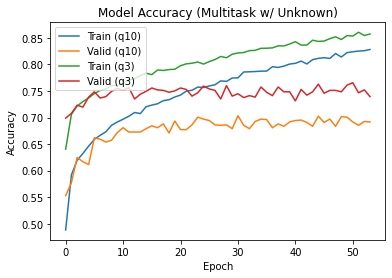

In [54]:
plt.plot(history.history['q10_accuracy'])
plt.plot(history.history['val_q10_accuracy'])
plt.plot(history.history['q3_accuracy'])
plt.plot(history.history['val_q3_accuracy'])
plt.title('Model Accuracy (Multitask w/ Unknown)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q3)', 'Valid (q3)'], loc='upper left')
plt.show()

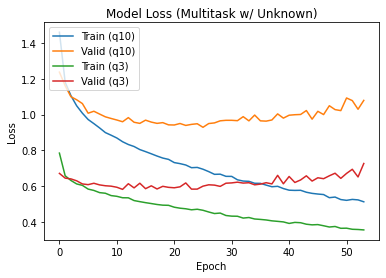

In [55]:
plt.plot(history.history['q10_loss'])
plt.plot(history.history['val_q10_loss'])
plt.plot(history.history['q3_loss'])
plt.plot(history.history['val_q3_loss'])
plt.title('Model Loss (Multitask w/ Unknown)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q3)', 'Valid (q3)'], loc='upper left')
plt.show()

In [56]:
model.evaluate(test_df, [to_categorical(test_lab_loc_u), to_categorical(test_lab_mem_u)])

2773/2773 [==============================] - 0s 65us/step


[2.1670517575813895,
 1.3054276704788208,
 0.8601503968238831,
 0.6393797397613525,
 0.710782527923584]

#### Masked Loss Function

Using a masked loss function to `mask` the loss from the unknown labels for the binary classification task, so that we can use all of the samples and still have q10 / q2 classification tasks.

In [57]:
id_dict_mem_masked = {
    'M': 0,
    'S': 1,
    'U': -1
}

In [58]:
# Create new label lists with ints instead of strings
train_lab_loc_u = [id_dict[label] for label in train_loc_labels_mtu]
valid_lab_loc_u = [id_dict[label] for label in valid_loc_labels_mtu]
test_lab_loc_u = [id_dict[label] for label in test_loc_labels_mtu]

train_lab_mem_u = [id_dict_mem[label] for label in train_mem_labels_mtu]
valid_lab_mem_u = [id_dict_mem[label] for label in valid_mem_labels_mtu]
test_lab_mem_u = [id_dict_mem[label] for label in test_mem_labels_mtu]

In [59]:
# This is where we mask out the unknown labels
mask_value = -1

def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [60]:
keras.backend.clear_session()

visible = keras.Input(shape=(768,))
h1 = Dense(32, activation='relu')(visible)
hf = Dense(32, activation='relu')(h1)

# NOTE: These commented out layers duplicate the diagram from the DeepLoc paper, 
# but did not perform as well as a DNN with two hidden layers of 32 nodes

# h1 = Dense(32, activation='relu')(visible)
# h2 = Dropout(0.25)(h1)
# hf = BatchNormalization()(h2)

output_q10 = Dense(10, activation='softmax', name='q10')(hf)
output_q2 = Dense(3, activation='softmax', name='q2')(hf)

model = keras.Model(inputs=visible, outputs=[output_q10, output_q2])
model.compile(loss=['categorical_crossentropy', masked_loss_function],
              optimizer='adam', metrics=['accuracy', 'accuracy'])

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.0001)
]

history = model.fit(train_df,
                    [to_categorical(train_lab_loc_u), to_categorical(train_lab_mem_u)],
                    validation_data=(valid_df, [to_categorical(valid_lab_loc_u), to_categorical(valid_lab_mem_u)]),
                    epochs=200, batch_size=64, callbacks=keras_callbacks)

Train on 9974 samples, validate on 1109 samples
Epoch 1/200
9974/9974 [==============================] - 1s 95us/step - loss: 2.0065 - q10_loss: 1.4856 - q2_loss: 0.5207 - q10_accuracy: 0.4941 - q2_accuracy: 0.6102 - val_loss: 1.6741 - val_q10_loss: 1.2476 - val_q2_loss: 0.4403 - val_q10_accuracy: 0.5437 - val_q2_accuracy: 0.6736
Epoch 2/200
9974/9974 [==============================] - 1s 68us/step - loss: 1.6001 - q10_loss: 1.1839 - q2_loss: 0.4161 - q10_accuracy: 0.5808 - q2_accuracy: 0.6901 - val_loss: 1.5077 - val_q10_loss: 1.1271 - val_q2_loss: 0.3923 - val_q10_accuracy: 0.6069 - val_q2_accuracy: 0.7304
Epoch 3/200
9974/9974 [==============================] - 0s 50us/step - loss: 1.4818 - q10_loss: 1.0906 - q2_loss: 0.3911 - q10_accuracy: 0.6159 - q2_accuracy: 0.7103 - val_loss: 1.4413 - val_q10_loss: 1.0699 - val_q2_loss: 0.3801 - val_q10_accuracy: 0.6195 - val_q2_accuracy: 0.7286
Epoch 4/200
9974/9974 [==============================] - 1s 61us/step - loss: 1.4191 - q10_loss: 1.0

Epoch 30/200
9974/9974 [==============================] - 0s 50us/step - loss: 0.9186 - q10_loss: 0.6333 - q2_loss: 0.2856 - q10_accuracy: 0.7849 - q2_accuracy: 0.8078 - val_loss: 1.2790 - val_q10_loss: 0.9391 - val_q2_loss: 0.3462 - val_q10_accuracy: 0.6943 - val_q2_accuracy: 0.7656
Epoch 31/200
9974/9974 [==============================] - 0s 45us/step - loss: 0.9007 - q10_loss: 0.6192 - q2_loss: 0.2815 - q10_accuracy: 0.7870 - q2_accuracy: 0.8115 - val_loss: 1.3029 - val_q10_loss: 0.9565 - val_q2_loss: 0.3521 - val_q10_accuracy: 0.6916 - val_q2_accuracy: 0.7556
Epoch 32/200
9974/9974 [==============================] - 0s 42us/step - loss: 0.8962 - q10_loss: 0.6141 - q2_loss: 0.2820 - q10_accuracy: 0.7871 - q2_accuracy: 0.8124 - val_loss: 1.2741 - val_q10_loss: 0.9292 - val_q2_loss: 0.3468 - val_q10_accuracy: 0.6961 - val_q2_accuracy: 0.7556
Epoch 33/200
9974/9974 [==============================] - 0s 48us/step - loss: 0.8912 - q10_loss: 0.6106 - q2_loss: 0.2807 - q10_accuracy: 0.7862

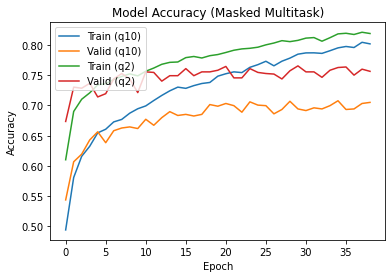

In [61]:
plt.plot(history.history['q10_accuracy'])
plt.plot(history.history['val_q10_accuracy'])
plt.plot(history.history['q2_accuracy'])
plt.plot(history.history['val_q2_accuracy'])
plt.title('Model Accuracy (Masked Multitask)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q2)', 'Valid (q2)'], loc='upper left')
plt.show()

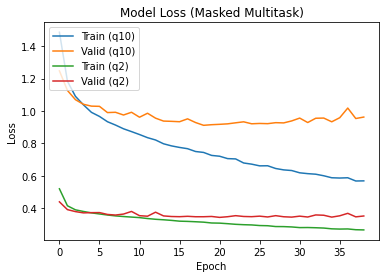

In [62]:
plt.plot(history.history['q10_loss'])
plt.plot(history.history['val_q10_loss'])
plt.plot(history.history['q2_loss'])
plt.plot(history.history['val_q2_loss'])
plt.title('Model Loss (Masked Multitask)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train (q10)', 'Valid (q10)', 'Train (q2)', 'Valid (q2)'], loc='upper left')
plt.show()

Masked Loss Function Results
* 72% accuracy on membrane bound vs water soluble protein
* 64% accuracy on subcellular location

In [63]:
model.evaluate(test_df, [to_categorical(test_lab_loc_u), to_categorical(test_lab_mem_u)])

2773/2773 [==============================] - 0s 31us/step


[1.5301723665938325,
 1.1144721508026123,
 0.4144045412540436,
 0.6437071561813354,
 0.7158312201499939]